##Save result to Google Drive

In [ ]:
from google.colab import drive
drive.mount('/gdrive', force_remount=True)

Mounted at /gdrive


##Install Transformer and import libraries

In [ ]:
pip install transformers

In [ ]:
import tensorflow as tf
import tensorflow_hub as hub
import pandas as pd
from sklearn.model_selection import train_test_split
import numpy as np
import re
import unicodedata
import nltk
import keras
from tqdm import tqdm
import pickle
from keras.models import Model
import keras.backend as K
from sklearn.metrics import confusion_matrix,f1_score,classification_report
from keras.callbacks import ModelCheckpoint
import itertools
from sklearn.utils import shuffle
import matplotlib.pyplot as plt

##Set up functions for pre-processing


In [ ]:
def unicode_to_ascii(s):
    return ''.join(c for c in unicodedata.normalize('NFD', s) if unicodedata.category(c) != 'Mn')

def clean_stopwords_shortwords(w):
    stopwords_list=stopwords.words('english')
    words = w.split() 
    clean_words = [word for word in words if (word not in stopwords_list) and len(word) > 2]
    return " ".join(clean_words) 

def preprocess_sentence(w):
    w = unicode_to_ascii(w.lower().strip())
    w = re.sub(r"([?.!,¿])", r" ", w)
    w = re.sub(r'[" "]+', " ", w)
    w = re.sub(r"[^a-zA-Z?.!,¿]+", " ", w)
    w=clean_stopwords_shortwords(w)
    w=re.sub(r'@\w+', '',w)
    return w

##Uploading Data

In [ ]:
from google.colab import files
uploaded = files.upload()

Saving FinAccumulatedPreppedData.csv to FinAccumulatedPreppedData.csv


In [ ]:
import io
data = pd.read_csv(io.BytesIO(uploaded['FinAccumulatedPreppedData.csv']))

In [ ]:
  data.head()

,id,text,cat_val
0,1,Serious question:\r\n\r\nWhat about the vaccin...,R
1,2,I don’t take medical advice from anybody who h...,G
2,3,Divide And Conquer Now Fully In Play! The Glob...,G
3,4,@DrLeanaWen Why do you propose that vaccinated...,M
4,5,God Bless @RepMTG !!!\r\n\r\nEven if they dont...,G


##Pre-process Data

In [ ]:
import nltk
nltk.download("stopwords")

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [ ]:
data=data.dropna()                                                           # Drop NaN valuues, if any
data=data.reset_index(drop=True)                                             # Reset index after dropping the columns/rows with NaN values
data = shuffle(data)                                                         # Shuffle the dataset
print('Available labels: ',data.cat_val.unique())                              # Print all the unique labels in the dataset
data['text']=data['text'].map(preprocess_sentence)                           # Clean the text column using preprocess_sentence function defined above

Available labels:  ['M' 'G' 'R']


##Set up Distil_Bert

In [ ]:
from transformers import BertTokenizer, TFBertModel, BertConfig, TFDistilBertForSequenceClassification, DistilBertTokenizer
num_classes = len(data.cat_val.unique())
dbert_tokenizer = DistilBertTokenizer.from_pretrained("distilbert-base-uncased")
dbert_model = TFDistilBertForSequenceClassification.from_pretrained('distilbert-base-uncased', num_labels = num_classes)

Downloading:   0%|          | 0.00/226k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/28.0 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/455k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/483 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/347M [00:00<?, ?B/s]

Some layers from the model checkpoint at distilbert-base-uncased were not used when initializing TFDistilBertForSequenceClassification: ['vocab_layer_norm', 'activation_13', 'vocab_projector', 'vocab_transform']
- This IS expected if you are initializing TFDistilBertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFDistilBertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some layers of TFDistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['dropout_95', 'pre_classifier', 'classifier']
You should probably TRAIN this model on a down-stream task to be able to use i

In [ ]:
data['gt'] = data['cat_val'].map({'G':0,'M':1,'R':2})
data.head()

sentences=data['text']
labels=data['gt']
len(sentences),len(labels)

(1057, 1057)

##Checking the inputs / Masked Task

In [ ]:
input_ids=[]
attention_masks=[]

for sent in sentences:
    dbert_inp=dbert_tokenizer.encode_plus(sent, add_special_tokens = True, max_length = 64, pad_to_max_length = True, return_attention_mask = True)
    input_ids.append(dbert_inp['input_ids'])
    attention_masks.append(dbert_inp['attention_mask'])

input_ids=np.asarray(input_ids)
attention_masks=np.array(attention_masks)
labels=np.array(labels)

/usr/local/lib/python3.7/dist-packages/transformers/tokenization_utils_base.py:2218: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  FutureWarning,


In [ ]:
len(input_ids),len(attention_masks),len(labels)


(1057, 1057, 1057)

In [ ]:
print('Preparing the pickle file.....')

pickle_inp_path='/gdrive/Shared drives/COMP484-Project/ModellingFiles/dbert_inp.pkl'
pickle_mask_path='/gdrive/Shared drives/COMP484-Project/ModellingFiles/dbert_mask.pkl'
pickle_label_path='/gdrive/Shared drives/COMP484-Project/ModellingFiles/dbert_label.pkl'

pickle.dump((input_ids),open(pickle_inp_path,'wb'))
pickle.dump((attention_masks),open(pickle_mask_path,'wb'))
pickle.dump((labels),open(pickle_label_path,'wb'))


print('Pickle files saved as ',pickle_inp_path,pickle_mask_path,pickle_label_path)

Preparing the pickle file.....
Pickle files saved as  /gdrive/Shared drives/COMP484-Project/ModellingFiles/dbert_inp.pkl /gdrive/Shared drives/COMP484-Project/ModellingFiles/dbert_mask.pkl /gdrive/Shared drives/COMP484-Project/ModellingFiles/dbert_label.pkl


In [ ]:
print('Loading the saved pickle files..')

input_ids=pickle.load(open(pickle_inp_path, 'rb'))
attention_masks=pickle.load(open(pickle_mask_path, 'rb'))
labels=pickle.load(open(pickle_label_path, 'rb'))

print('Input shape {} Attention mask shape {} Input label shape {}'.format(input_ids.shape,attention_masks.shape,labels.shape))

Loading the saved pickle files..
Input shape (1057, 64) Attention mask shape (1057, 64) Input label shape (1057,)


##Split data (Train, Test)

In [ ]:
train_inp,val_inp,train_label,val_label,train_mask,val_mask=train_test_split(input_ids,labels,attention_masks,test_size=0.2)

print('Train inp shape {} Val input shape {}\nTrain label shape {} Val label shape {}\nTrain attention mask shape {} Val attention mask shape {}'.format(train_inp.shape,val_inp.shape,train_label.shape,val_label.shape,train_mask.shape,val_mask.shape))

Train inp shape (845, 64) Val input shape (212, 64)
Train label shape (845,) Val label shape (212,)
Train attention mask shape (845, 64) Val attention mask shape (212, 64)


##Compile the model

In [ ]:
log_dir='/gdrive/Shared drives/COMP484-Project/ModellingFiles/tb_dbert'
model_save_path='/gdrive/Shared drives/COMP484-Project/ModellingFiles/models/dbert_model.h5'

callbacks = [
             tf.keras.callbacks.EarlyStopping(patience = 2),
             tf.keras.callbacks.ModelCheckpoint(filepath=model_save_path,save_weights_only=True,monitor='val_loss',mode='min',save_best_only=True),
             tf.keras.callbacks.TensorBoard(log_dir=log_dir)]

print('\nDistil Bert Model',dbert_model.summary())

loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)
metric = tf.keras.metrics.SparseCategoricalAccuracy('accuracy')
optimizer = tf.keras.optimizers.Adam(learning_rate=2e-5, epsilon=1e-08)

dbert_model.compile(loss=loss,optimizer=optimizer,metrics=[metric])

Model: "tf_distil_bert_for_sequence_classification"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 distilbert (TFDistilBertMai  multiple                 66362880  
 nLayer)                                                         
                                                                 
 pre_classifier (Dense)      multiple                  590592    
                                                                 
 classifier (Dense)          multiple                  2307      
                                                                 
 dropout_95 (Dropout)        multiple                  0         
                                                                 
Total params: 66,955,779
Trainable params: 66,955,779
Non-trainable params: 0
_________________________________________________________________

Distil Bert Model None


##Train the model

In [ ]:
history=dbert_model.fit(
    [train_inp,train_mask],
    train_label,
    batch_size=32,
    epochs=10,
    validation_data=([val_inp,val_mask],val_label),
    callbacks=callbacks)

Epoch 1/10
27/27 [==============================] - 338s 12s/step - loss: 0.1966 - accuracy: 0.9243 - val_loss: 1.0916 - val_accuracy: 0.6604
Epoch 2/10
27/27 [==============================] - 309s 11s/step - loss: 0.1720 - accuracy: 0.9337 - val_loss: 1.0214 - val_accuracy: 0.6792
Epoch 3/10
27/27 [==============================] - 324s 12s/step - loss: 0.1516 - accuracy: 0.9325 - val_loss: 0.8937 - val_accuracy: 0.7594
Epoch 4/10
27/27 [==============================] - 321s 12s/step - loss: 0.1543 - accuracy: 0.9349 - val_loss: 0.9656 - val_accuracy: 0.7311
Epoch 5/10
27/27 [==============================] - 325s 12s/step - loss: 0.1635 - accuracy: 0.9290 - val_loss: 0.9100 - val_accuracy: 0.6934


##Analysis of model

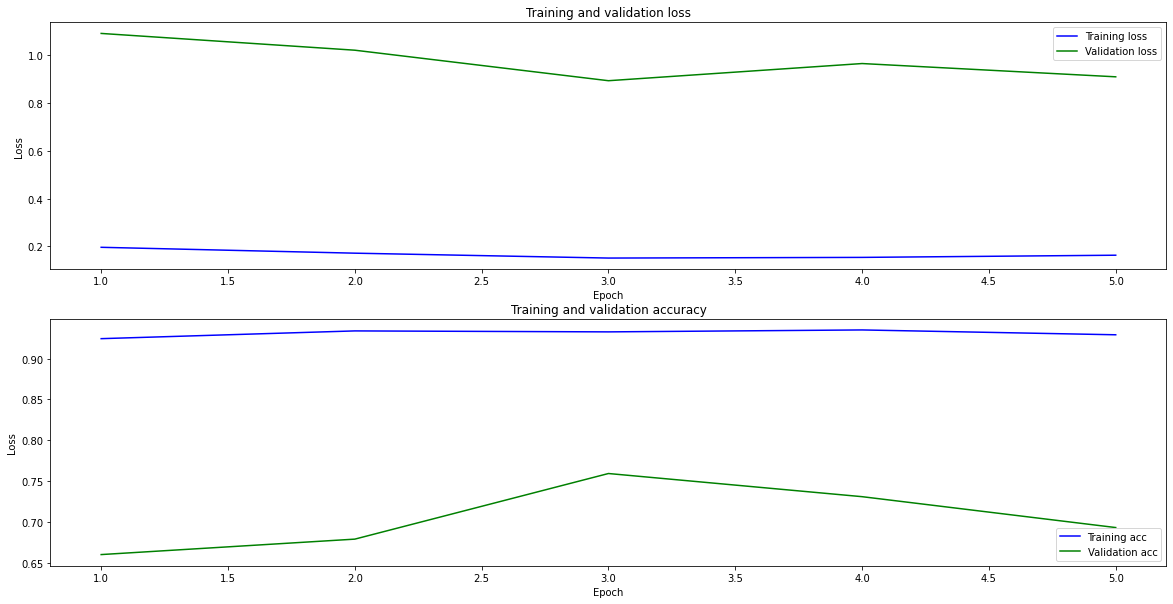

In [ ]:
history_dict = history.history
# print(history_dict.keys())

loss = history_dict['loss']
acc = history_dict['accuracy']
val_loss = history_dict['val_loss']
val_acc = history_dict['val_accuracy']

epoches = range(1, 6)
fig = plt.figure(figsize=(20,10))
fig.tight_layout()

plt.subplot(2,1,1) #nrow, ncol, index
plt.plot(epoches, loss, 'blue', label = 'Training loss')
plt.plot(epoches, val_loss, 'green', label = 'Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.subplot(2,1,2) #nrow, ncol, index
plt.plot(epoches, acc, 'b', label = 'Training acc')
plt.plot(epoches, val_acc, 'g', label = 'Validation acc')
plt.title('Training and validation accuracy')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()


##Analysis of Data

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


Text(0.5, 0, 'Distribution of categories')

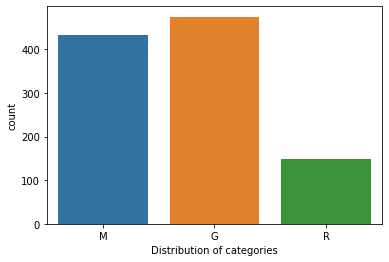

In [ ]:
import seaborn as sns

sns.countplot(data.cat_val)
plt.xlabel('Distribution of categories')